In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from typing import Tuple

## CIS编码

 $$ f(q, m) = qe^{im\theta}$$
 $$ f(q, m) =  \begin{pmatrix}
  \cos(m\theta) & -\sin(m\theta) \\
  \sin(m\theta) & \cos(m\theta)
 \end{pmatrix} \begin{pmatrix} q^0 \\ q^1 \end{pmatrix}$$ 
 $$ R(\alpha)R(\beta) = R(\alpha+\beta) $$
 $$ R^T(\alpha)R(\beta) =\begin{pmatrix}
  \cos(\alpha) & \sin(\alpha) \\
  -\sin(\alpha) & \cos(\alpha)
 \end{pmatrix} \begin{pmatrix}
  \cos(\beta) & -\sin(\beta) \\
  \sin(\beta) & \cos(\beta)
 \end{pmatrix} 
  \\ = R(-\alpha)R(\beta) \\ = R(\beta-\alpha)$$
  


In [16]:
x = torch.randn(2,3)
y = torch.randn(3,2)
torch.matmul(x,y), torch.transpose(torch.matmul(x,y), 0, 1)


(tensor([[-0.2747,  0.7961],
         [-0.0549, -0.9413]]),
 tensor([[-0.2747, -0.0549],
         [ 0.7961, -0.9413]]))

In [21]:
print(y.T)
print(torch.transpose(y,0,1))
torch.matmul(y.T, x.T, )

tensor([[-0.1203, -0.2416,  0.2817],
        [ 0.4160,  0.5174,  0.0102]])
tensor([[-0.1203, -0.2416,  0.2817],
        [ 0.4160,  0.5174,  0.0102]])


tensor([[-0.2747, -0.0549],
        [ 0.7961, -0.9413]])

$$ (R_mq)^T = q^T R_m^T$$

In [11]:
def R(theta):
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]])

In [19]:
R1 = R(30)
R2 = R(60)
print(R1.T.dot(R2))
print(R(60-30))

[[ 0.8660254 -0.5      ]
 [ 0.5        0.8660254]]
[[ 0.8660254 -0.5      ]
 [ 0.5        0.8660254]]


## apply_rotary_emb

| **model** | **heads** | **layers** | **dim** | **head_dim** |
|-----------|-----------|------------|---------|--------------|
| 7b        | 32        | 32         | 4096    | 4096/32      |
| 13b       | 40        | 40         | 5120    | 5120/40      |
| 70b       | 64        | 80         | 8192    | 8192/64      |

- position encoding 直接作用于 q(query) 与 k(key)
    - `q = wq(x)`
    - `k = wk(x)`
- 是一种乘性，而非 sin position encoding 的加性；
    - BERT（Transformer库）的 position encoding 也是加性的；

## 远程（$m-n$）衰减性

- Transformer升级之路：2、博采众长的旋转式位置编码
    - https://spaces.ac.cn/archives/8265/comment-page-1

$$
\begin{split}
&S_j=\sum_{i=0}^{j-1}\exp(i(m-n)\theta_i)\\
&\theta_i=10000^{-2i/d}
\end{split}
$$

In [22]:
def apply_rotary_emb(
    xq: torch.Tensor,
    xk: torch.Tensor,
    freqs_cis: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    
    # [1, 8, 32, 128] => [1, 8, 32, 64] (*2)
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    # [1, 8, 32, 128] => [1, 8, 32, 64] (*2)
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    
    # [8, 64] => [1, 8, 1, 64]
    freqs_cis = reshape_for_broadcast(freqs_cis, xq_)
    
    # (xq_ * freqs_cis).shape == [1, 8, 32, 64]
    # torch.view_as_real(xq_ * freqs_cis).shape == [1, 8, 32, 64, 2]
    # flatten(3) == [1, 8, 32, 128]
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    
    # xq_out == [1, 8, 32, 128]
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

In [23]:
def s(m, d=128):
    theta_i = lambda i: 10000**(-2*i/d)
    return np.sum([np.abs(np.sum(np.exp(1j*m*theta_i(np.arange(0, j))))) for j in range(0, d//2)])

In [24]:
d = 128
xs = np.arange(256)
ys = [s(x)/(d//2) for x in xs]

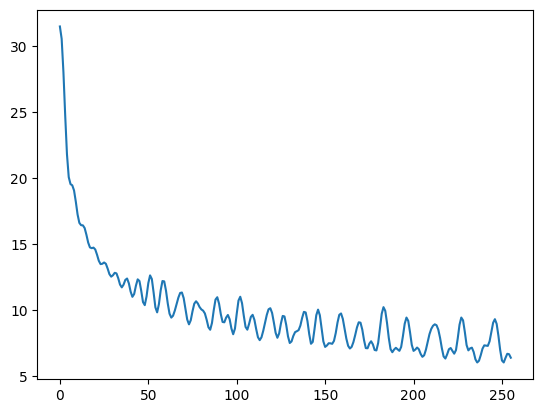

In [25]:
plt.plot(xs, ys)